In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.externals import joblib
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
df = pd.read_csv('books.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'Harold Bindloss', 'Edward Phillips Oppenheim',
       'John Galsworthy', 'Daniel Defoe', 'William Makepeace Thackeray',
       'Herbert George Wells', 'Edmund Burke', 'Mark Twain',
       'Sir Arthur Conan Doyle', 'Lord Byron', 'Jack London',
       'Robert Louis Stevenson', 'John Ruskin', 'Charles Kingsley',
       'Charles Dickens', 'James Fenimore Cooper', 'John Bunyan',
       'Sir Walter Scott', 'R M Ballantyne', 'Jacob Abbott'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,Harold Bindloss,Edward Phillips Oppenheim,John Galsworthy,Daniel Defoe,William Makepeace Thackeray,Herbert George Wells,Edmund Burke,Mark Twain,Sir Arthur Conan Doyle,...,Jack London,Robert Louis Stevenson,John Ruskin,Charles Kingsley,Charles Dickens,James Fenimore Cooper,John Bunyan,Sir Walter Scott,R M Ballantyne,Jacob Abbott
0,0,"was marked, the company paid small dividends a...","""that you saw me. Are you up at this hour ever...","her effect, she broke off suddenly, and hastil...","them and to me. First, he turned to me, and po...","such a woman, of which the fruition could neve...",EXPERIMENTS; OF GRAND MONARCHY ...,"perpetuity or on lives, after the tax of 1...",stands. How strange it seems--this place! Th...,"designs, and had simply wished to obtain first...",...,dead reckoning can never calculate. Before lon...,the thought of what you may have seen off a fo...,"we that dream."" _Essay on Criticism._ [260] ...",gleam of pathos and tenderness seemed to shin...,have taken a great deal of pains with his whis...,"smooth water, and with a whole-sail breeze, it...","shall but in one point offend, Breaks the whol...","Evandale's horse, which instantly sunk down de...",also for making acquaintance with the products...,The Rollo Books by Jacob Abbott [Illustra...
1,1,"as much before."" ""I did,"" said Holbrook. ""Th...","with the plowman by his side, but without any ...",regular black Highlander. What's the trouble e...,on exactly what conditions he was released fro...,"of Miss Lowther, and singing with her out of t...",long time.... Buzard rose out of waves of sub...,of the present campaign. By those two capitula...,assumed the horizontal in the bottom of the bo...,"best."" ""I perceive,"" said the prince, ""that y...",...,"most for least, he faces a frightful slavery s...","done, and Lawless a prisoner in the church. ""...","royal pilotage, being on the whole the most ...",intellectual growth and ferment which communic...,"idea yet, of Estella's views on the adoration ...",happy; the success of the day having infused a...,that he would make the very bed shake under hi...,beyond the pitch of most minds; and however ob...,"to our prospects of finding deer hereabouts, a...","usual custom, he began his conversation by say..."
2,2,make for Tomlinson. He had been a strong and h...,"leaned forward in her chair, gazing steadily i...","never smiled. Aunt Juley's bewildered, ""Fancy...",[183] London Bridge. [184] This incident is s...,"go to the very verge of caricature, and yet ne...",grey outline against the shimmer of the moon; ...,"understand, to be sure, that I speak of Charle...",full of strong drink and patriotism; within fi...,The Hound of the Baskervilles by Sir Arthur ...,...,of courage; and the end of the battle found hi...,"cents. It's all found money to him, the way it...",Europæa._ _Night-jar of Europe_ ...,"looked at, and a fresh Dryad gazed out of eve...",returning to London. Charles Dickens remained...,"that service, for want of a good system; and c...",justified in the sight of God; so it is also a...,I have this day learned more of Duke Charles t...,"head in, than out came a most awful growl. Th...","gratification and improvement of the child, if..."
3,3,"Mrs. Ratcliffe smiled approvingly at last. ""Ye...",the blowing away of the window was merely a ru...,again. I don't want---- He breaks off a...,tradesman ruined by marrying a good wife--in w...,"so much. He is not a clever man----"" ""He cert...","the earth. There is our Prince. He is in me, h...",rather than to the jury as matter of popular j...,"acquiring sudden wealth was to ""salt"" a wild c...","76th, 81st, and 82nd (Colonel McDonnell). Besi...",...,"breath in a half-sob, then tightened her lips ...","and a quieter. They draw fine ale, however--fa...",that he is ashamed to confess; with all that l...,"therefore shall she not be removed."" It seems...",pen again; and before he went to bed wrote ano...,"time mentioned, the vehicle drew up before the.

Fit the TFid Vectorizer on all the dataset

In [5]:
all_texts = df[df.columns[1:]].values
print(all_texts.shape)
all_texts = all_texts.flatten()
all_texts.shape

vectorizer = TfidfVectorizer(strip_accents='ascii', max_df=0.6)
vectorizer.fit(all_texts)

print(len(vectorizer.vocabulary_))

(20, 20)
180578


Make a new dataframe for classification

In [6]:
data = pd.DataFrame(columns=['author_name','text'])

In [7]:
for column in df.columns[1:]: 
    for text in df[column].values:
        data = data.append({
                'author_name': column,
                'text': text
            }, ignore_index=True)

Transform all the texts

In [8]:
data['transformed_text'] = data['text'].transform(lambda text: vectorizer.transform([text]).toarray().flatten())

In [9]:
data['author_id'] = pd.factorize(data['author_name'])[0]

In [10]:
data.head()

,author_name,text,transformed_text,author_id
0,Harold Bindloss,"was marked, the company paid small dividends a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,Harold Bindloss,"as much before."" ""I did,"" said Holbrook. ""Th...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,Harold Bindloss,make for Tomlinson. He had been a strong and h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,Harold Bindloss,"Mrs. Ratcliffe smiled approvingly at last. ""Ye...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,Harold Bindloss,"but how illogical!"" Grace remarked, and mused ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [30]:
X = list(data['transformed_text'].values)
y = data['author_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, )

In [38]:
def best_results(model, parameters):
    results = pd.DataFrame(model.cv_results_)
    columns = [f'param_{key}'for key in parameters.keys()] + ['rank_test_score', 'mean_test_score']

    return list(results[columns]
             .sort_values(by='rank_test_score')[:5]
             .T
             .to_dict()
             .values())

def evaluate_classification_model(model, X, y):
    print('Best Parameters of GridSearch ', model.best_params_)
    
    print('Models score', model.score(X, y))
    
    y_pred = model.predict(X)
    print('Classification Report')
    print(classification_report(y, y_pred))
    
    cm = confusion_matrix(y, y_pred)
    plot_confusion_matrix(cm, data['author_name'].unique())

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
params = {
    'C': np.arange(1, 1.5, 0.1),
    'kernel': ['linear'],
    'gamma': [0.01, 0.05, 0.1]
}
model = GridSearchCV(SVC(), param_grid=params, cv=3, n_jobs=-1, verbose=2)


model.fit(list(X_train), y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.6min finished
/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([ 1. ,  1.1,  1.2,  1.3,  1.4]), 'kernel': ['linear'], 'gamma': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Best Parameters of GridSearch  {'C': 1.1000000000000001, 'gamma': 0.01, 'kernel': 'linear'}
Models score 0.97
Accuracy score
0.97
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.57      1.00      0.73         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         8
           8       1.00      0.83      0.91         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         8
          14       1.00      1.00    

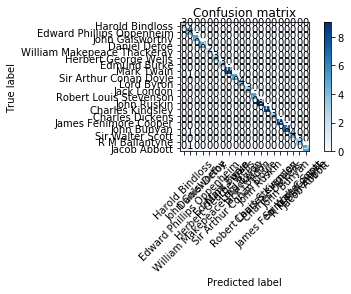

In [39]:
evaluate_classification_model(model, X_test, y_test)

In [60]:
model = SVC(C=1.1000000000000001, gamma=0.01, kernel='linear')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.89000000000000001

## SVM Classification using PCA

In [47]:
parameters = {
    'pca__n_components': np.arange(5, 190, 5, dtype=np.int16),
    'svc__C': [1.4, 1.1],
    'svc__gamma': [0.01, 0.1],
    
    'svc__kernel': ['linear']
    
}
model = GridSearchCV(make_pipeline(PCA(), SVC()), parameters, cv=3, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)

Fitting 3 folds for each of 148 candidates, totalling 444 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 444 out of 444 | elapsed: 22.6min finished
/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185], dtype=int16), 'svc__C': [1.4, 1.1], 'svc__gamma': [0.01, 0.1], 'svc__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Best Parameters of GridSearch  {'pca__n_components': 120, 'svc__C': 1.4, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Models score 0.85
Accuracy score
0.85
Classification Report
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.57      1.00      0.73         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       0.50      1.00      0.67         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         8
           8       1.00      0.50      0.67         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       0.75      0.60      0.67         5
          12       1.00      1.00      1.00         9
          13       1.00      0.88      0.93         8
          14

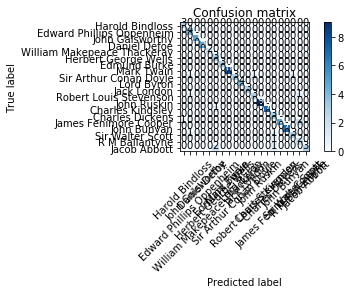

In [48]:
evaluate_classification_model(model, X_test, y_test)

In [49]:
pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score')[:5]

/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.war

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
117,48.911014,1.033006,1.585499,0.133420,150,1.4,0.1,linear,"{'pca__n_components': 150, 'svc__C': 1.4, 'svc...",0.847619,0.862745,0.817204,0.843333,0.018606,1,1.0,1.0,1.0,1.0,0.0
121,54.766570,2.153897,1.435695,0.081789,155,1.4,0.1,linear,"{'pca__n_components': 155, 'svc__C': 1.4, 'svc...",0.847619,0.852941,0.827957,0.843333,0.010541,1,1.0,1.0,1.0,1.0,0.0
120,58.904079,0.936229,1.420045,0.031515,155,1.4,0.01,linear,"{'pca__n_components': 155, 'svc__C': 1.4, 'svc...",0.847619,0.852941,0.827957,0.843333,0.010541,1,1.0,1.0,1.0,1.0,0.0
93,40.457028,0.869578,1.491152,0.018905,120,1.4,0.1,linear,"{'pca__n_components': 120, 'svc__C': 1.4, 'svc...",0.857143,0.852941,0.817204,0.843333,0.017600,1,1.0,1.0,1.0,1.0,0.0
141,55.778151,1.343606,1.442393,0.112842,180,1.4,0.1,linear,"{'pca__n_components': 180, 'svc__C': 1.4, 'svc...",0.847619,0.852941,0.827957,0.843333,0.010541,1,1.0,1.0,1.0,1.0,0.0


In [53]:
parameters = {
    'pca__n_components': np.arange(100, 200, 5, dtype=np.int16),
    'svc__C': [1.1],
    'svc__gamma': [0.01],
    'svc__kernel': ['linear']
    
}
model = GridSearchCV(make_pipeline(PCA(), SVC()), parameters, cv=3, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.5min finished
/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
       165, 170, 175, 180, 185, 190, 195], dtype=int16), 'svc__C': [1.1], 'svc__gamma': [0.01], 'svc__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Best Parameters of GridSearch  {'pca__n_components': 185, 'svc__C': 1.1, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
Models score 0.89
Accuracy score
0.89
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.44      1.00      0.62         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       0.50      1.00      0.67         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         8
           8       1.00      0.67      0.80         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         9
          13       1.00      0.88      0.93         8
          1

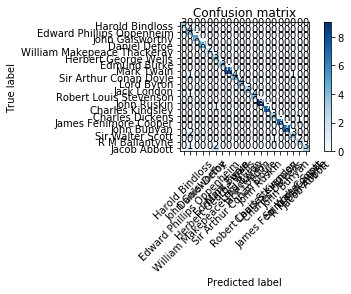

In [54]:
evaluate_classification_model(model, X_test, y_test)

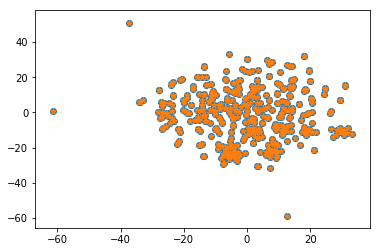

In [66]:
tsne = TSNE(n_components=2)
x_embd = tsne.fit_transform(X)
plt.scatter(x_embd[:, 0], x_embd[:, 1])
plt.scatter(x_embd[:, 0], x_embd[:, 1], marker='*')

## Clustering

In [20]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score

In [13]:
X = data['transformed_text'].values
y = np.zeros(X.shape)
X = list(X)

In [50]:
pca2 = PCA(n_components=100)
X_train = pca2.fit_transform(X)
kmeans = KMeans(n_clusters=5, init='random')
kmeans.fit(X_train)


0.108398054345


In [59]:
epsilon = np.arange(0.7, 2, 0.1)

for e in epsilon:
    cluster = {}
    dbscan = DBSCAN(eps=e)
    dbscan.fit(X)
    cluster["algorithm"] = "DBSCAN"
    cluster["labels"] = dbscan.labels_
    cluster["parameters"] = {'eps': e}

    unique, counts = np.unique(dbscan.labels_, return_counts=True)
    print("eps:",e,"clusters:", dict(zip(unique, counts)))

eps: 0.7 clusters: {-1: 388, 0: 7, 1: 5}
eps: 0.8 clusters: {-1: 379, 0: 6, 1: 10, 2: 5}
eps: 0.9 clusters: {-1: 365, 0: 8, 1: 5, 2: 15, 3: 7}
eps: 1.0 clusters: {-1: 341, 0: 5, 1: 8, 2: 7, 3: 5, 4: 8, 5: 19, 6: 7}
eps: 1.1 clusters: {-1: 304, 0: 5, 1: 5, 2: 6, 3: 18, 4: 8, 5: 14, 6: 7, 7: 25, 8: 8}
eps: 1.2 clusters: {-1: 264, 0: 8, 1: 8, 2: 11, 3: 56, 4: 12, 5: 5, 6: 26, 7: 10}
eps: 1.3 clusters: {-1: 187, 0: 163, 1: 8, 2: 14, 3: 14, 4: 6, 5: 3, 6: 5}
eps: 1.4 clusters: {0: 400}
eps: 1.5 clusters: {0: 400}
eps: 1.6 clusters: {0: 400}
eps: 1.7 clusters: {0: 400}
eps: 1.8 clusters: {0: 400}
eps: 1.9 clusters: {0: 400}


In [62]:
for n in np.arange(5, 20):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    print("n: ", n, " clusters:", dict(zip(unique, counts)))

n:  5  clusters: {0: 324, 1: 25, 2: 14, 3: 20, 4: 17}
n:  6  clusters: {0: 17, 1: 25, 2: 302, 3: 20, 4: 6, 5: 30}
n:  7  clusters: {0: 9, 1: 25, 2: 20, 3: 260, 4: 34, 5: 42, 6: 10}
n:  8  clusters: {0: 11, 1: 15, 2: 25, 3: 34, 4: 26, 5: 259, 6: 21, 7: 9}
n:  9  clusters: {0: 238, 1: 13, 2: 25, 3: 19, 4: 48, 5: 21, 6: 17, 7: 9, 8: 10}
n:  10  clusters: {0: 8, 1: 19, 2: 27, 3: 18, 4: 23, 5: 21, 6: 10, 7: 56, 8: 210, 9: 8}
n:  11  clusters: {0: 52, 1: 14, 2: 21, 3: 10, 4: 4, 5: 25, 6: 18, 7: 216, 8: 21, 9: 8, 10: 11}
n:  12  clusters: {0: 178, 1: 10, 2: 25, 3: 10, 4: 35, 5: 23, 6: 33, 7: 22, 8: 24, 9: 18, 10: 13, 11: 9}
n:  13  clusters: {0: 47, 1: 10, 2: 10, 3: 18, 4: 150, 5: 15, 6: 14, 7: 9, 8: 10, 9: 19, 10: 53, 11: 11, 12: 34}
n:  14  clusters: {0: 25, 1: 135, 2: 19, 3: 9, 4: 23, 5: 18, 6: 10, 7: 22, 8: 13, 9: 18, 10: 12, 11: 43, 12: 12, 13: 41}
n:  15  clusters: {0: 6, 1: 13, 2: 9, 3: 18, 4: 48, 5: 14, 6: 24, 7: 35, 8: 9, 9: 8, 10: 15, 11: 21, 12: 10, 13: 21, 14: 149}
n:  16  cluster

In [74]:
for n in np.arange(20, 30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    print(silhouette_score(X, kmeans.labels_))
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    print("n: ", n, " clusters:", dict(zip(unique, counts)))

0.0562609774015
n:  20  clusters: {0: 30, 1: 4, 2: 9, 3: 29, 4: 18, 5: 10, 6: 25, 7: 20, 8: 9, 9: 18, 10: 5, 11: 10, 12: 13, 13: 7, 14: 3, 15: 9, 16: 18, 17: 8, 18: 148, 19: 7}
0.0583114562708
n:  21  clusters: {0: 9, 1: 25, 2: 24, 3: 16, 4: 28, 5: 52, 6: 4, 7: 52, 8: 3, 9: 27, 10: 18, 11: 8, 12: 9, 13: 26, 14: 10, 15: 18, 16: 8, 17: 10, 18: 7, 19: 32, 20: 14}
0.053163452214
n:  22  clusters: {0: 15, 1: 83, 2: 11, 3: 13, 4: 8, 5: 32, 6: 8, 7: 3, 8: 25, 9: 8, 10: 50, 11: 7, 12: 7, 13: 34, 14: 9, 15: 20, 16: 9, 17: 19, 18: 9, 19: 8, 20: 9, 21: 13}
0.0593065883293
n:  23  clusters: {0: 27, 1: 25, 2: 18, 3: 9, 4: 12, 5: 26, 6: 8, 7: 16, 8: 8, 9: 13, 10: 31, 11: 3, 12: 28, 13: 12, 14: 10, 15: 6, 16: 11, 17: 10, 18: 15, 19: 2, 20: 87, 21: 15, 22: 8}
0.0591182214528
n:  24  clusters: {0: 8, 1: 13, 2: 18, 3: 25, 4: 20, 5: 21, 6: 7, 7: 9, 8: 16, 9: 8, 10: 8, 11: 3, 12: 131, 13: 3, 14: 18, 15: 9, 16: 4, 17: 26, 18: 6, 19: 9, 20: 13, 21: 8, 22: 12, 23: 5}
0.0538188178789
n:  25  clusters: {0: 48,

Around 20-25 clusters the distortion value doesn't change a lot.
There is still a cluster that has 100+ but the other cluesters are kind of equal. By plotting the values using PCA with 2 components we can't see a clear separation of clusters

0.0591402381463


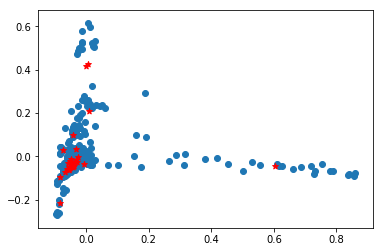

In [73]:
pca = PCA(n_components=2)
x_emdb = pca.fit_transform(X)
clusters = pca.transform(kmeans.cluster_centers_)
print(silhouette_score(X, kmeans.labels_))
plt.scatter(x_emdb[:, 0], x_emdb[:, 1])
plt.scatter(clusters[:, 0], clusters[:, 1], marker='*', c='red')

In [64]:
for n in np.arange(5, 20):
    agg = AgglomerativeClustering(n_clusters=n)
    agg.fit(X)
    unique, counts = np.unique(agg.labels_, return_counts=True)
    print(silhouette_score(X, agg.labels_))
    print("n: ", n, " clusters:", dict(zip(unique, counts)))

0.0295553677671
n:  5  clusters: {0: 38, 1: 21, 2: 307, 3: 26, 4: 8}
0.0333111453922
n:  6  clusters: {0: 307, 1: 21, 2: 18, 3: 26, 4: 8, 5: 20}
0.0384988582625
n:  7  clusters: {0: 21, 1: 299, 2: 18, 3: 26, 4: 8, 5: 20, 6: 8}
0.0407861816598
n:  8  clusters: {0: 299, 1: 26, 2: 18, 3: 12, 4: 8, 5: 20, 6: 8, 7: 9}
0.0442475231043
n:  9  clusters: {0: 290, 1: 26, 2: 18, 3: 9, 4: 8, 5: 20, 6: 8, 7: 9, 8: 12}
0.0466865870836
n:  10  clusters: {0: 284, 1: 26, 2: 18, 3: 9, 4: 6, 5: 20, 6: 8, 7: 9, 8: 12, 9: 8}
0.0490219446988
n:  11  clusters: {0: 278, 1: 26, 2: 18, 3: 9, 4: 6, 5: 20, 6: 8, 7: 9, 8: 12, 9: 8, 10: 6}
0.0528960857823
n:  12  clusters: {0: 275, 1: 26, 2: 18, 3: 9, 4: 6, 5: 20, 6: 8, 7: 9, 8: 12, 9: 8, 10: 6, 11: 3}
0.0559945730593
n:  13  clusters: {0: 272, 1: 26, 2: 18, 3: 9, 4: 6, 5: 20, 6: 8, 7: 9, 8: 12, 9: 8, 10: 6, 11: 3, 12: 3}
0.0582316573455
n:  14  clusters: {0: 26, 1: 265, 2: 18, 3: 9, 4: 6, 5: 20, 6: 7, 7: 9, 8: 12, 9: 8, 10: 6, 11: 3, 12: 3, 13: 8}
0.0541572913481


In [65]:
for n in np.arange(20, 30):
    agg = AgglomerativeClustering(n_clusters=n)
    agg.fit(X)
    unique, counts = np.unique(agg.labels_, return_counts=True)
    print(silhouette_score(X, agg.labels_))
    print("n: ", n, " clusters:", dict(zip(unique, counts)))

0.060684541987
n:  20  clusters: {0: 163, 1: 96, 2: 20, 3: 13, 4: 10, 5: 6, 6: 7, 7: 9, 8: 12, 9: 6, 10: 6, 11: 3, 12: 3, 13: 8, 14: 16, 15: 3, 16: 3, 17: 5, 18: 3, 19: 8}
0.0621842276938
n:  21  clusters: {0: 96, 1: 149, 2: 20, 3: 13, 4: 14, 5: 6, 6: 7, 7: 9, 8: 12, 9: 10, 10: 6, 11: 3, 12: 3, 13: 8, 14: 16, 15: 3, 16: 3, 17: 5, 18: 3, 19: 8, 20: 6}
0.063474248721
n:  22  clusters: {0: 149, 1: 50, 2: 20, 3: 13, 4: 14, 5: 6, 6: 7, 7: 9, 8: 12, 9: 10, 10: 46, 11: 3, 12: 3, 13: 8, 14: 16, 15: 3, 16: 3, 17: 5, 18: 3, 19: 8, 20: 6, 21: 6}
0.0656092868026
n:  23  clusters: {0: 50, 1: 14, 2: 20, 3: 13, 4: 46, 5: 6, 6: 7, 7: 9, 8: 12, 9: 10, 10: 4, 11: 3, 12: 3, 13: 8, 14: 16, 15: 3, 16: 3, 17: 5, 18: 3, 19: 8, 20: 6, 21: 6, 22: 145}
0.0690766836024
n:  24  clusters: {0: 14, 1: 46, 2: 20, 3: 13, 4: 4, 5: 6, 6: 7, 7: 9, 8: 12, 9: 10, 10: 145, 11: 3, 12: 3, 13: 8, 14: 16, 15: 3, 16: 3, 17: 5, 18: 3, 19: 8, 20: 6, 21: 6, 22: 48, 23: 2}
0.0704153583233
n:  25  clusters: {0: 46, 1: 4, 2: 20, 3: 13

The results of Kmeans and Agglomerative are not verry different

In [71]:
print('Adjusted rand ', adjusted_rand_score(kmeans.labels_, agg.labels_))
print('Homogenity score ', homogeneity_score(kmeans.labels_, agg.labels_))
print('Completness score ', completeness_score(kmeans.labels_, agg.labels_))

Adjusted rand  0.17203085835718337
Homogenity score  0.545740796335
Completness score  0.664117243198
